In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [4]:
names = open("../names.txt", "r").read().splitlines()
names[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

## Problem 
Learn to generate name-like words.
## Model 
Character-based language model which predicts the next character in a fixed-size sequence (context). To generate words, we give the model previously generated characters as a context (initially special zero-symbols) and generate the next, until it is a special symbol indicating the end of the word.
## Implementation
A model is an MLP learning on the name dataset. Each character is represented by its' feature vector (embedding).
### Input
**h_context_size** embedding vectors corresponding to given context, merged into one **h_context_size** * **h_emb_dim** -dimensional vector
### Output
Discrete probability distribution over **alph_size** items (corresponding to characters in the alphabet). The distribution is obtained by applying *softmax* to the last hidden layer
### Hidden layers
The number of hidden layers and their sizes are the hyperparameters. Each hidden layer uses *tanh* as its' non-linearity
### Metrics
Cross-entropy loss (negative log likelihood of the training set)

In [3]:
# convert index to character
itoc = list(set(list(''.join(names))))
itoc.sort()
itoc = ['.'] + itoc

# convert character to index
ctoi = {itoc[i] : i for i in range(len(itoc))}

# Data consts
alph_size = len(itoc)

In [4]:
# Because the format of processed data (and the number of training samples) depends on hyperparameters (h_context_size), 
# we split the raw data into train, dev and test sets and then re-process them (but do not change the initial data) when we change hyperparameters
import random
random.seed(27) # for reproducibility

random.shuffle(names)
train_size = int(0.8 * len(names))
dev_size = int(0.1 * len(names))

train_set = names[:train_size]
dev_set = names[train_size:train_size + dev_size]
test_set = names[train_size + dev_size:]
print(len(train_set), len(dev_set), len(test_set))

25626 3203 3204


In [5]:
# Hyperparams

h_context_size = 4 # number of characters to predict the next
h_emb_dim = 8 # embedding space dimension
h_hidden_sizes = [250] # sizes of hidden layers
h_lr = 1 # learning rate (modifiable during the training)
h_mb_size = 80 # minibatch size

In [6]:
# Build dataset

def build_dataset(raw):
    X = []
    Y = []
    for word in raw: # for demonstration
        # print(word)
        context = [0] * h_context_size
        for ch in word + '.':
            X.append(context)
            Y.append(ctoi[ch])
            # print(''.join([itoc[i] for i in context]), '-->', ch)
            context = context[1:] + [ctoi[ch]]
    return torch.tensor(X), torch.tensor(Y)

X_tr, Y_tr = build_dataset(train_set)
X_dev, Y_dev = build_dataset(dev_set)
X_test, Y_test = build_dataset(test_set)
X_tr.shape, Y_tr.shape

(torch.Size([182351, 4]), torch.Size([182351]))

In [7]:
# Initialize params

gen = torch.Generator().manual_seed(3806539) # for reproducibility

p_hidden = [] # hidden layers' weights and biases
for size1, size2 in zip([h_emb_dim * h_context_size] + h_hidden_sizes, h_hidden_sizes + [alph_size]): # 
    p_hidden.append(
        (torch.randn((size1, size2), generator=gen), # layer weights (size1 inputs, size2 neurons)
         torch.randn((size2,), generator=gen))       # neurons' biases (size2 in total)
    )

C = torch.randn((alph_size, h_emb_dim), generator=gen) # embedding matrix
params = [C] + [W for (W, _) in p_hidden] + [b for (_, b) in p_hidden]
print([(W.shape, b.shape) for (W, b) in p_hidden])
print(C.shape)
print(sum([p.nelement() for p in params])) # model size

[(torch.Size([32, 250]), torch.Size([250])), (torch.Size([250, 27]), torch.Size([27]))]
torch.Size([27, 8])
15243


In [8]:
# Training utilities

def sample_minibatch(X_all, Y_all):
    ind = torch.randint(0, X_all.shape[0], (h_mb_size,), generator=gen)
    return X_all[ind], Y_all[ind]

def embed(X):
    return C[X].view(-1, h_emb_dim * h_context_size) # preserves gradient propagation

def forward(X):
    current = embed(X)
    for (W, b) in p_hidden[:-1]:
        current = torch.tanh(current @ W + b) # pass the data through the layer and add non-linearity (notice tensor broadcast)
    W_out, b_out = p_hidden[-1]
    return current @ W_out + b_out # create logits (no non-linearity) on the output layer

def reset_grad():
    for p in params:
        p.grad = None

def update(lr):
    for p in params:
        p.data -= lr * p.grad

def train(iter):
    for i in range(iter):
        X_mb, Y_mb = sample_minibatch(X_tr, Y_tr)
        loss = F.cross_entropy(forward(X_mb), Y_mb)
        reset_grad()
        loss.backward()
        update(h_lr)

# To set custom learning rates and keep track of loss
def train_inspect(iter, lri, inspect_steps):
    stepi, lossi = [], []
    for i, lr in zip(range(iter), lri):
        X_mb, Y_mb = sample_minibatch(X_tr, Y_tr)
        loss = F.cross_entropy(forward(X_mb), Y_mb)
        reset_grad()
        loss.backward()
        update(lr)
        if i % int(iter / inspect_steps) == 0:
            lossi.append(loss.item())
            stepi.append(i)
    return stepi, lossi

In [9]:
# Validation and testing utilities

def eval(X, Y):
    return F.cross_entropy(forward(X), Y).item()

In [10]:
# Prepare for training

for p in params:
    p.requires_grad = True

In [11]:
# Utilities to analyze and select hparams

def moving_average(data, window_size):
    window = torch.ones((window_size,)) / window_size;
    return np.convolve(data, window, 'same')

def trim(list, offset):
    return list[offset:-offset]

def plot_smooth(X, Y, smoothing_factor):
    avg_window_size = int(smoothing_factor * len(X))
    plt.plot(trim(X, avg_window_size), trim(Y, avg_window_size))
    plt.plot(trim(X, avg_window_size), trim(moving_average(Y, avg_window_size), avg_window_size))

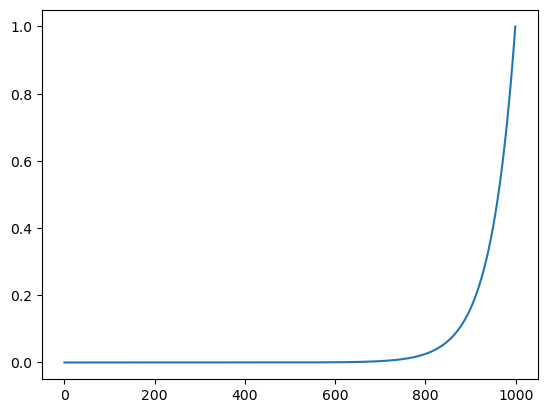

In [12]:
# Generate exponentially increasing (to provide ordinal uniformity) learning rates between current and <very small> value

cur_lr_exp = torch.log10(torch.tensor(h_lr)).item()
lri = 10 ** torch.linspace(cur_lr_exp - 8, cur_lr_exp, 1000)
plt.plot(torch.arange(lri.shape[0]), lri)

In [13]:
# Find optimal learning rate

stepi, tr_lossi = train_inspect(lri.shape[0], lri, lri.shape[0])

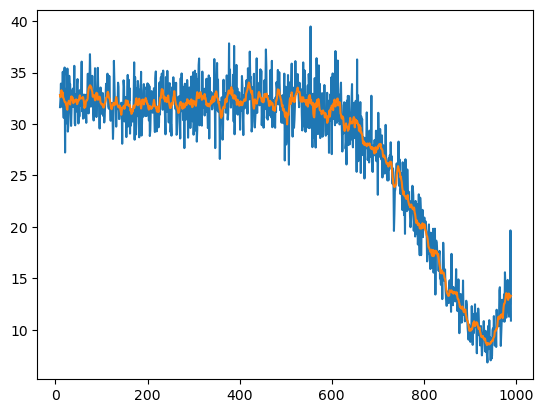

In [14]:
plot_smooth(stepi, tr_lossi, 0.01)
# plot_smooth(stepi[800:1000], tr_lossi[800:1000], 0.1)

In [15]:
h_lr = lri[940].item()
h_lr

0.3369205892086029

In [16]:
# Train model keeping track of the loss
iter = 50000
lri = torch.ones((iter,)) * h_lr

stepi, tr_lossi = train_inspect(iter, lri, iter)

In [17]:
print(eval(X_tr, Y_tr), eval(X_dev, Y_dev))

2.86299204826355 2.9438254833221436


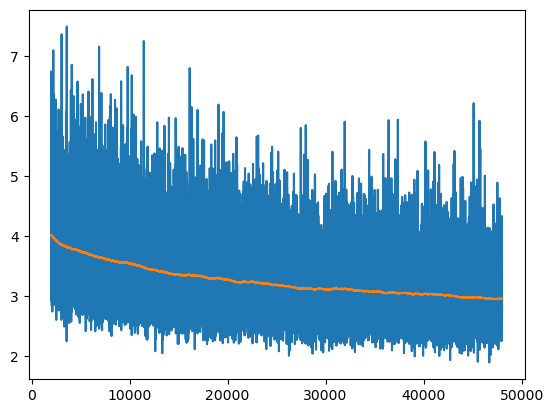

In [18]:
plot_smooth(stepi, tr_lossi, 0.04)

In [19]:
[((p ** 2).sum() / p.nelement()).item() for p in params] # regularization not needed

[1.320462703704834,
 1.0541609525680542,
 0.40424203872680664,
 1.3621045351028442,
 1.0628046989440918]

In [20]:
# Sampling from the model

sampler = torch.Generator().manual_seed(3806539) # for reproducibility

def gen_next_char(context):
    distribution = F.softmax(forward(context), dim=1)
    sample = torch.multinomial(distribution, num_samples=1, generator=sampler).item()
    return itoc[sample]

def gen_word():
    word = ''
    context = [0] * h_context_size
    while True:
        next = gen_next_char(context)
        if (next == '.'):
            break
        context = context[1:] + [ctoi[next]]
        word += next
    return word

def generate(num_samples):
    res = []
    for _ in range(num_samples):
        res.append(gen_word())
    return res

print(names[:20]) # real names
generate(20) # model's predictions

['zemora', 'saliou', 'zhaniyah', 'amire', 'alinea', 'damian', 'vianka', 'maha', 'ameira', 'jahon', 'romulus', 'gurveer', 'avea', 'laylonnie', 'maja', 'shane', 'aasim', 'javier', 'alaiza', 'efraim']


['honsynn',
 'yosefina',
 'suge',
 'tonora',
 'psylii',
 'leez',
 'koonsha',
 'rosson',
 'thoinn',
 'sonilynn',
 'lylyn',
 'tolynn',
 'lole',
 'lophyffy',
 'yossyanna',
 'someryna',
 'copontriyah',
 'laeejnadyn',
 'lopen',
 'corestynnlonn']

In [21]:
eval(X_test, Y_test)

2.944058418273926

In [22]:
# Results

# Hparams:
# (1): context_size = 5, emb_dim = 10, hidden_sizes = [150], mb_size = 40
# (2): context_size = 4, emb_dim = 8, hidden_sizes = [250], mb_size = 80

# Minimal loss obtained
# (1) train_loss = 2.14, val_loss = 2.17
# (2) train_loss = 2.04, val_loss = 2.13

# (2) test_loss = 2.14
# Examples of samples from (2):

#  'hila',
#  'prand',
#  'adarimsuon',
#  'shealanishia',
#  'caleza',
#  'rohab',
#  'emida',
#  'nylee',
#  'mitarnik',
#  'grael',
#  'khayalyra',
#  'joleth',
#  'quyos',
#  'caylay',
#  'press',
#  'marquavin',
#  'borah',
#  'tane',
#  'emra',
#  'cytle'

#  'charlingston',
#  'warlon',
#  'lyric',
#  'slamarie',
#  'alire',
#  'aly',
#  'mamuela',
#  'maisenceran',
#  'kharchon',
#  'zaman',
#  'maziah',
#  'rain',
#  'trysce',
#  'sayon',
#  'rakeseah',
#  'alivsarion',
#  'kalavis',
#  'kakquila',
#  'khaya',
#  'sallen'